In [34]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import *
import os
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# DATA_DIR_L =  ""
# DATA_DIR = DATA_DIR_L

DATA_DIR_M = "/home/masa/Downloads/google-cloud-sdk/our_data"
DATA_DIR = DATA_DIR_M

In [35]:
# We use spark session in order to use DataFrames
ss = SparkSession.builder \
    .appName("GoogleClusterAnalysis") \
    .master("local[2]") \
    .getOrCreate()

In [36]:
ss.sparkContext.setLogLevel("ERROR")

### 1. What is the distribution of the machines according to their CPU capacity? Can you explain (motivate) it?

In [37]:
machine_schema = StructType([
    StructField('timestamp', LongType(), True),
    StructField('machine_ID', LongType(), True),
    StructField('event_type', IntegerType(), True),
    StructField('platform_ID', StringType(), False),
    StructField('CPUs', DoubleType(), False),
    StructField('memory_capacity', DoubleType(), False),
    ])

In [38]:
df_machines = ss.read.csv(os.path.join(DATA_DIR,"machine_events/*.csv.gz"), schema=machine_schema)
df_machines.limit(5).toPandas()

,timestamp,machine_ID,event_type,platform_ID,CPUs,memory_capacity
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [39]:
# Count distinct machines in df_machines
df_machines.select('machine_ID').distinct().count()

12583

In [40]:
# Count occuring event_types (according to documentation there are three (ADD(0), REMOVE(1), UPDATE(2))
df_machines.select("event_type").distinct().count()

3

In [41]:
# Count the occurance of event_type 0 (ADD)
df_machines.filter(df_machines["event_type"] == 0).distinct().count()

21443

In [42]:
# Count the distinct number of event_type 0 (ADD) at timestamp 0 (when machines are started)
total_count_t0 = df_machines.filter(df_machines["timestamp"] == 0).distinct().count()
total_count_t0

12477

In [43]:
# Count the distinct machines at timestamp 0 (varifying numbers)
df_machines.select("machine_ID").filter(df_machines["timestamp"] == 0).distinct().count()

12477

In [44]:
# Check if every machine has one CPU
df_machines.groupBy("machine_ID").agg(F.count_distinct("CPUs").alias("distinct_cpus")).filter(F.col("distinct_cpus") > 1).show()

+----------+-------------+
|machine_ID|distinct_cpus|
+----------+-------------+
+----------+-------------+



We conclude that only one CPUs value can be taken by one machine!

In [45]:
# Display the type of CPUs machines are using at timestamp 0
df_machines.select("CPUs").filter(df_machines["timestamp"] == 0).distinct().toPandas()

,CPUs
0,1.00
1,0.50
2,0.25


In [46]:
df_cpu_count = df_machines.select(['machine_ID', 'CPUs']).filter(df_machines["timestamp"] == 0).groupby('CPUs').count()
df_cpu_count.toPandas()

,CPUs,count
0,1.00,791
1,0.50,11563
2,0.25,123


In [47]:
df_cpu_count.withColumn("percentage", F.round((F.col("count") / total_count_t0) * 100)).toPandas()

,CPUs,count,percentage
0,1.00,791,6.0
1,0.50,11563,93.0
2,0.25,123,1.0


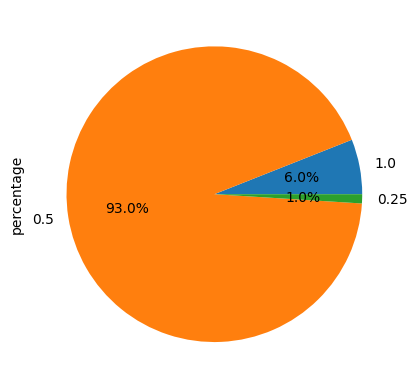

In [154]:
df_cpu_per = df_cpu_count.withColumn("percentage", F.round((F.col("count") / total_count_t0) * 100)).toPandas()

ax = df_cpu_per.plot.pie(y='percentage', autopct='%1.1f%%', labels=df_cpu_per['CPUs'], legend=False)
fig = ax.get_figure()
fig.savefig('images/cpu_distribution_pie.png', bbox_inches='tight', dpi=300)

**Answer:** At timestamp "0" there are 12,477 machines initially started. The CPU capacity of the machines can be grouped into three types of capacity volumes (0.25, 0.5 and 1). 1% of the machines use 0.25 CPUs, 6% 1.0 CPUs and 93% were using 0.5 CPUs when initally started. According to the documentation, these capacities are normalised, and it states that "The normalization is a scaling relative to the largest capacity of the resource on any machine in the trace (which is 1.0)."

One reason for the majority of CPUs being at 0.5 capacity could be that it is easier to maintain the machines if they all have a similar hardware meaning a similar CPU, e.g. to have fewer types of spare CPU in stock. Having a "standard" CPU will also reduce the complexity of scheduling jobs and tasks, as the machines are fairly homogenous and tasks can be scheduled without much computation.

### 2. What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)? The computational power is proportional to both the CPU capacity and the unavailability period of machines.

The documentation states that, "event_type = 1" means that a machine was removed from the cluster. Removals can occur due to
failures or maintenance. Therefore, we want to find all the times a machine was removed and then reconnected later (event_type = 0 in a time step after the event_type = 1).

In [49]:
from pyspark.sql import Window

In [50]:
window = Window.partitionBy("machine_ID").orderBy("timestamp")

df_next = df_machines.withColumn("next_event_type", F.lead("event_type").over(window))
df_next = df_next.withColumn("next_time", F.lead("timestamp").over(window))

df_next.limit(5).toPandas()

,timestamp,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,next_time
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,1.0,8.351507e+11
1,835150655707,5,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0.0,8.361249e+11
2,836124903464,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,NaN,NaN
3,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,NaN,NaN
4,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,NaN,NaN


By partitioning the window by machine_id, we ensure that all events types are processed independently for each machine. In that way, we are sure that event pairings will refer to the same physical machine.

The lead() function returns the following event and time for the same machine. Previously, we ordered events by timestamp, and therefore, "next" refers to the next chronological event in that machine's sequence of events. In that way, we can be sure that we are identifying distinct offline intervals without overlappings.

In [51]:
# this is just a check to see if time intervals are not overlapping, and if event types of previous and next event_type are matching
df_next.filter(df_next["machine_ID"] == 43).limit(5).toPandas()

,timestamp,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,next_time
0,0,43,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,2,372991930737
1,372991930737,43,2,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,2,373198072841
2,373198072841,43,2,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,2,727861243083
3,727861243083,43,2,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,2,736148630106
4,736148630106,43,2,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,2,736768939531


Now, we want to filter df_next to reflect only situations when machine went offline and was reloaded afterwards. That can be achieved by observing event_type=1 followed by next_event=0

In [52]:
df_reloaded = df_next.filter((df_next["event_type"]==1) & (df_next["next_event_type"]==0))
df_reloaded.count()

8860

We notice that this number matches the number of such observed cases of reloaded machines that were mentioned in paper: https://www.researchgate.net/publication/261164671_Characterizing_Machines_and_Workloads_on_a_Google_Cluster  on page 3 (Figure 3) which tells us we're on good trace.

In [53]:
# Here we just extract offline time in a column named "offline_time"
df_reloaded = df_reloaded.withColumn("offline_time", F.col("next_time").cast("long")-F.col("timestamp").cast("long")).drop("timestamp", "next_time")
df_reloaded.limit(5).toPandas()

,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,offline_time
0,5,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,974247757
1,10,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,998726348
2,13,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,997280215
3,23,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,120851153
4,26,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,88666880740


Now we want to calculate lost resources for each sample as a product of offline time and CPUs, and then we sum over all samples.

In [54]:
# multiply offline time and CPU
df_reloaded = df_reloaded.withColumn("power_lost", df_reloaded["offline_time"]*df_reloaded["CPUs"])
total_power_lost = df_reloaded.agg(F.sum("power_lost")).collect()[0][0]
total_power_lost

80273246292457.75

Now, in order to find percentage of lost resources, we want to find possible total power

In [55]:
total_cpu = df_machines.select("machine_ID", "CPUs").agg(F.sum("CPUs")).collect()[0]["sum(CPUs)"]
trace_bounds = df_machines.agg(
    F.min("timestamp").alias("start"),
    F.max("timestamp").alias("end")
).collect()[0]
total_time = trace_bounds["end"] - trace_bounds["start"]

total_power = total_cpu * total_time

In [56]:
percentage_lost = total_power_lost/total_power * 100
print(f"Percentage of computational power lost: {percentage_lost:.4f}%")

Percentage of computational power lost: 0.1613%


**Answer:** Over all machines and for the whole covered period, we conclude that the total percentage of computational power lost due to mainenance (and failures) is 0.16%.

## 3. Is there a class of machines, according to their CPU, that stands out with a higher maintenance rate, as compared to other classes ?

Here, by maintenance rate, we observe how frequently machines undergo maintenance (or else: offline periods). We want to see if there is a class of machines (grouped by their CPU capacity) that experiences longer or more frequent maintenance periods compared to others. 

We calculate maintenance rate as a total_offline_time per machine divided by total_time (already calculated in previous task). We will use already calculated df_reloaded from previous task

In [152]:
# check df from task 2
df_reloaded.limit(3).toPandas()

,machine_ID,event_type,platform_ID,CPUs,memory_capacity,next_event_type,offline_time,power_lost
0,5,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,974247757,487123878.5
1,10,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,998726348,499363174.0
2,13,1,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493,0,997280215,498640107.5


In [58]:
df_reloaded.count()

8860

In [59]:
total_time

2506135493517

In [60]:
df_offline_times = df_reloaded.groupBy("machine_ID", "CPUs").agg(F.sum("offline_time").alias("total_offline_time"))
df_offline_times.limit(3).toPandas()

,machine_ID,CPUs,total_offline_time
0,5,0.5,974247757
1,10,0.5,998726348
2,13,0.5,997280215


In [61]:
df_offline_times = df_offline_times.withColumn(
    "maintenance_rate_percentage", 
    F.col("total_offline_time").cast("double") * 100 / total_time)
df_offline_times.limit(3).toPandas()

,machine_ID,CPUs,total_offline_time,maintenance_rate_percentage
0,5,0.5,974247757,0.038875
1,10,0.5,998726348,0.039851
2,13,0.5,997280215,0.039794


In [62]:
# manually check for machine 5
974247757 / 2506135493517 * 100

0.038874504571689526

In [63]:
df_offline_times.groupBy("CPUs").agg(F.avg("maintenance_rate_percentage")).toPandas()

,CPUs,avg(maintenance_rate_percentage)
0,1.00,0.797648
1,0.50,1.237891
2,0.25,1.915000


In [ ]:
# todo: some plot

**Result:** From here, we conclude that machines with lowest CPU capacity (0.25) have the highest average maintenance rate (~1.92%) <br>
Therefore, the conclusion is that lower-CPU machines tend to have higher downtimes (maintenance and failures), which means they either undergo maintenance more frequently or for longer periods.


### 4. What is the distribution of the number of jobs/tasks per scheduling class? Comment on the results.

In [64]:
# Define schema for job events table
job_events_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("job_name", StringType(), True),
    StructField("logical_job_name", StringType(), True)
])

In [65]:
df_job_events = ss.read.csv(os.path.join(DATA_DIR,"job_events/*.csv.gz"), schema=job_events_schema)
df_job_events.limit(5).toPandas()

,timestamp,missing_info,job_id,event_type,user_name,scheduling_class,job_name,logical_job_name
0,772325004610,None,6319958772,1,ZpQmujQYX55FcN2RFvqqUkcz5z/Tovj2FaG8sFtlG48=,0,4iFTcCfph6IhTG3o4wYegeDbshbOLsVmej89GFCe+bo=,AmKr63lD9MIGXiAacmzoj6kQMGqk2U0M89A2RkgB6uc=
1,772325045338,None,6319984350,0,E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=,1,UaXnrc6huaDo9qNtX9ukOIn8h7t8fOT2Ovcv9+GSsKQ=,Mz+7hmVdCFVQEwwuv/CoVxcc2YEG/CPiY4GZi3YyLKE=
2,772325074372,None,6319983180,0,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,2,ct6ai8SyqLEEEdgBSqx9Pw5iuhMahN3L81jZKfFedD4=,G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8=
3,772326178083,None,6319984385,0,F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c=,0,aPxb6dFdH8wZ2FTBCDuRFDFmTkCuuAJHXUSj1woB7C0=,j25eTfDZ4FFHzd7p+VKe13tP4+iQbKkHk9VI0SBK/nE=
4,772327671789,None,6319983180,1,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,2,ct6ai8SyqLEEEdgBSqx9Pw5iuhMahN3L81jZKfFedD4=,G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8=


In [66]:
# define schema for task events table
task_events_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("req_cpu_cores", DoubleType(), True),
    StructField("req_ram", DoubleType(), True),
    StructField("req_local_disk", DoubleType(), True),
    StructField("different_machine_constraint", BooleanType(), True)
])

In [67]:
df_task_events = ss.read.csv(os.path.join(DATA_DIR,"task_events/*.csv.gz"), schema=task_events_schema)
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


In [68]:
# Count number of unique jobs per scheduling class
# groupBy creates groups based on scheduling_class
# agg with count counts the number of job_ids in each group
jobs_per_class = df_job_events.select("job_id", "scheduling_class").distinct().groupBy("scheduling_class").agg(F.count("job_id").alias("num_of_jobs"))

jobs_per_class.toPandas()

,scheduling_class,num_of_jobs
0,1,2977
1,3,110
2,2,2525
3,0,3158


In [69]:
# Calculate total number of unique jobs in the dataset
# counts distinct job_ids across all events to get the absolute total
total_jobs = df_job_events.select("job_id").distinct().count()
total_jobs

8770

In [70]:
# Calculate total number of unique jobs in the dataset
# counts distinct job_ids across all events to get the absolute total
total_jobs_task_events = df_task_events.select("job_id").distinct().count()
total_jobs_task_events

9642

In [71]:
# verify total_jobs
2977 + 110 + 2525 + 3158

8770

In [72]:
jobs_per_class_df = jobs_per_class.withColumn("job_percentage", F.round((F.col("num_of_jobs") / total_jobs) * 100))
jobs_per_class_df.toPandas()

,scheduling_class,num_of_jobs,job_percentage
0,1,2977,34.0
1,3,110,1.0
2,2,2525,29.0
3,0,3158,36.0


In [73]:
# Count number of unique tasks per scheduling class
# groupBy creates groups based on scheduling_class
# agg with count counts the number of job_ids in combination with task_index in each group
tasks_per_class = df_task_events.select("job_id", "task_index", "scheduling_class").distinct().groupBy("scheduling_class").agg(F.count("*").alias("num_of_tasks"))

tasks_per_class.toPandas()

,scheduling_class,num_of_tasks
0,1,32864
1,3,2590
2,2,9607
3,0,285756


In [74]:
# Calculate total number of unique jobs in the dataset
# counts distinct combination of job_ids and task_index across all events to get the absolute total
total_tasks = df_task_events.select("job_id", "task_index").distinct().count()
total_tasks

330817

In [75]:
tasks_per_class_df = tasks_per_class.withColumn("task_percentage", F.round((F.col("num_of_tasks") / total_tasks) * 100))
tasks_per_class_df.toPandas()

,scheduling_class,num_of_tasks,task_percentage
0,1,32864,10.0
1,3,2590,1.0
2,2,9607,3.0
3,0,285756,86.0


In [76]:
# Result joined dataframe
result = jobs_per_class_df.join(tasks_per_class_df, "scheduling_class", "inner")
result.toPandas()

,scheduling_class,num_of_jobs,job_percentage,num_of_tasks,task_percentage
0,1,2977,34.0,32864,10.0
1,3,110,1.0,2590,1.0
2,2,2525,29.0,9607,3.0
3,0,3158,36.0,285756,86.0


Based on 8770 (xybjdsahfhuisad)

**Scheduling Class Distribution:**
- Class 0 (non-production): ~36% of jobs and 86% of task, this suggests non-production jobs tend to have many tasks per job
- Class 1: 34% of jobs, 10% of tasks
- Class 2: 29% of jobs, 3% of tasks  
- Class 3 (most latency-sensitive): Only 1% of both jobs and tasks, indicating production workloads are a small but critical portion of the cluster

**->** Non-production workloads (class 0) dominate task count and job count, suggesting they involve large-scale data processing jobs with many parallel tasks while, as the "Google documentation" notes, class 3 represents more latency-senstive tasks in production, being potentially short-lived and fast.

### 5. Would you qualify the percentage of jobs/tasks that got killed or evicted as important? 

In [77]:
# Define event type constants for readability
EVICT = 2
KILL = 5

# Count unique jobs that were killed or evicted at least once across its lifecycle
jobs_killed_evicted = df_job_events.filter(F.col("event_type").isin([EVICT, KILL])).select("job_id").distinct().count()
jobs_killed_evicted

3997

In [78]:
# Calculate percentage (using the total_jobs from question 4 = all jobs that had at least one task scheduled)
perc_jobs_killed_evicted = round(jobs_killed_evicted / total_jobs * 100)
perc_jobs_killed_evicted

46

In [79]:
# Break down by event type "KILL"
jobs_killed = df_job_events.filter(F.col("event_type") == KILL).select("job_id").count()
jobs_killed

3997

In [80]:
# Break down by event type "EVICT"
jobs_evicted = df_job_events.filter(F.col("event_type") == EVICT).select("job_id").count()
jobs_evicted

0

In [81]:
# Count unique tasks that were killed or evicted at least once across its lifecycle
tasks_killed_evicted = df_task_events.filter(F.col("event_type").isin([EVICT, KILL])).select("task_index", "job_id").distinct().count()
tasks_killed_evicted

141832

In [82]:
# Calculate percentage (using total_task from question 4 = all tasks with a distinct combination of job_ids and task_index)
perc_tasks_killed_evicted = round(tasks_killed_evicted / total_tasks * 100)
perc_tasks_killed_evicted

43

In [83]:
# Break down by event type "KILL"
tasks_killed = df_task_events.filter(F.col("event_type")== KILL).select("task_index").count()
tasks_killed

138951

In [84]:
# Break down by event type "EVICT"
tasks_evicted = df_task_events.filter(F.col("event_type")== EVICT).select("task_index").count()
tasks_evicted

83227

Out of all jobs 46% of them were killed, out of all scheduled tasks (330817) 43% of them were killed or evicted at least once. There were no evict events at job level. 

Especially because of these high numbers, the percentage of evictions and kills is highly important. Nearly half of all jobs and tasks experience termination. This is a substantial portion of the workload that doesn't complete successfully on the first attempt and can reflect system reliability indicators. 

The high numbers might reflect the scheduling strategy from Google, as the documentation notes: "it can happen that there are not enough resources to meet all the runtime requests from the tasks, even though each of them is using less than its limit. If this happens, one or more low priority task(s) may be killed." The high number of evictions (83,227 task evictions) demonstrates that lower-priority tasks, which also make up 36% of all jobs and 86% of all tasks, may act as a "buffer" for cluster capacity, being evicted when resources are needed for higher-priority tasks. 

### 6. Do tasks with a low scheduling class have a higher probability of being evicted?

In [85]:
# visual check of df
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


In [86]:
# filter df for evicted tasks (reusing code from question 5)
df_tasks_evicted = df_task_events.filter(F.col("event_type") == EVICT).select("task_index", "scheduling_class")
df_tasks_evicted.toPandas()

,task_index,scheduling_class
0,101,0
1,118,0
2,1367,0
3,432,0
4,463,1
...,...,...
83222,842,1
83223,772,1
83224,1318,0
83225,76,1


In [87]:
# group evicted tasks by scheduling class and count them
df_tasks_evicted_count = df_tasks_evicted.groupBy("scheduling_class").count()
df_tasks_evicted_count.toPandas()

,scheduling_class,count
0,1,17086
1,3,873
2,2,3253
3,0,62015


In [88]:
# calculate percentage
df_tasks_evicted_count.withColumn("percentage", F.round((F.col("count") / tasks_evicted) * 100)).toPandas()

,scheduling_class,count,percentage
0,1,17086,21.0
1,3,873,1.0
2,2,3253,4.0
3,0,62015,75.0


The analysis of 83,227 task evictions show that tasks with a lower scheduling class are evicted more often than tasks with a higher scheduling class. Tasks from class 0 (non-production) make up 75% of all evictions, class 1 21%, class 2 4& and class 3 (most latency-sensitive tasks) only 1%. 

As the  documentation explicitly states "The cluster scheduler attempts to prevent latency-sensitive tasks at these priorities from being evicted due to over-allocation of machine resources."

This explains why class 0 tasks get evicted the most and why higher scheduling classes have some protection against eviction.
The documentation states that EVICT events occur due to: "a higher priority task or job, because the scheduler overcommitted and the actual demand exceeded the machine capacity, because the machine on which it was running became unusable (e.g. taken offline for repairs), or because a disk holding the task's data was lost."

As already assumed in question 5, non-production workloads serve as a resource buffer and get sacrificed to enable the cluster to maintain responsiveness for production workloads.

While Class 0 and 1 dominate evictions by volume, Classes 3-4 still experience eviction rates of 1% to 4%. This indicates that even higher scheduling classes can be evicted under certain conditions (machine failures, extreme resource pressure).

### 7. In general, do tasks from the same job run on the same machine? Comment on the observed locality strategy and its pros and cons.

In [89]:
# visual check of df
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


In [90]:
# filtering for only scheduled tasks
df_scheduled = df_task_events.filter(F.col("event_type") == 1)

In [91]:
# for each job count number of unique tasks and number of unique machines used

df_jobs_machines = df_scheduled.groupBy("job_ID").agg(
    F.countDistinct("task_index").alias("num_of_tasks"),
    F.countDistinct("machine_ID").alias("num_of_machines")
)

df_jobs_machines.toPandas()

,job_ID,num_of_tasks,num_of_machines
0,6318966074,652,868
1,6319490931,450,437
2,6319448540,250,269
3,6051350394,1,3
4,6320614703,50,50
...,...,...,...
9093,6318822085,1,1
9094,6320197917,1,1
9095,6319201363,1,1
9096,6319105742,1,1


In [92]:
tasks_per_machine = df_jobs_machines.withColumn("tasks_per_machine", F.col("num_of_tasks") / F.col("num_of_machines"))
tasks_per_machine.toPandas()

,job_ID,num_of_tasks,num_of_machines,tasks_per_machine
0,6318966074,652,868,0.751152
1,6319490931,450,437,1.029748
2,6319448540,250,269,0.929368
3,6051350394,1,3,0.333333
4,6320614703,50,50,1.000000
...,...,...,...,...
9093,6318822085,1,1,1.000000
9094,6320197917,1,1,1.000000
9095,6319201363,1,1,1.000000
9096,6319105742,1,1,1.000000


In [93]:
# sort list into patterns 
task_per_machine = tasks_per_machine.withColumn(
    "category",
    F.when(F.col("num_of_machines") == 1, "all_on_one") # all task of jobs run on the same machine (one task job)
     .when(F.col("tasks_per_machine") > 1, "multiple_tasks_per_machine") # multiple tasks run on a machine
     .when(F.col("tasks_per_machine") == 1, "fully_distributed") # 1 task per machine 
     .when(F.col("tasks_per_machine") < 1, "over_distributed") # more machines than tasks
     .otherwise("?")
)
task_per_machine.toPandas()

,job_ID,num_of_tasks,num_of_machines,tasks_per_machine,category
0,6318966074,652,868,0.751152,over_distributed
1,6319490931,450,437,1.029748,multiple_tasks_per_machine
2,6319448540,250,269,0.929368,over_distributed
3,6051350394,1,3,0.333333,over_distributed
4,6320614703,50,50,1.000000,fully_distributed
...,...,...,...,...,...
9093,6318822085,1,1,1.000000,all_on_one
9094,6320197917,1,1,1.000000,all_on_one
9095,6319201363,1,1,1.000000,all_on_one
9096,6319105742,1,1,1.000000,all_on_one


In [94]:
category_counts = task_per_machine.groupBy("category").agg(F.count("*").alias("num_of_tasks"))
category_counts.toPandas()

,category,num_of_tasks
0,all_on_one,6125
1,over_distributed,980
2,multiple_tasks_per_machine,151
3,fully_distributed,1842


In [95]:
# this is counting the unique jobs in the task_events table, this number differs from the unique jobs from job_events
total_scheduled_jobs = task_per_machine.select("job_id").distinct().count()
total_scheduled_jobs

9098

Analysis based on 9098 jobs that had at least one task scheduled (event_type=1) in the task_events table.

In [96]:
# to verify the number of total_jobs, this line checks the unique jobs in df_jobs_scheduled
# which is a dataframe of task_events with event_type = 1 
total_scheduled_jobs_2 = df_scheduled.select("job_id").distinct().count()
total_scheduled_jobs_2

9098

In [97]:
# manually verifying the total_jobs from category_counts table
6125 + 980 + 151 + 1842

9098

In [98]:
# calculate percentage
category_counts.withColumn("percentage", F.round((F.col("num_of_tasks") / total_scheduled_jobs) * 100)).toPandas()

,category,num_of_tasks,percentage
0,all_on_one,6125,67.0
1,over_distributed,980,11.0
2,multiple_tasks_per_machine,151,2.0
3,fully_distributed,1842,20.0


As the category "all_on_one" contains single-task jobs (num_tasks = 1), which trivially run on one machine only, since there's only one task to place, the analysis is restructured to multi-task-jobs only.

In [99]:
multi_task_jobs = task_per_machine.filter(F.col("num_of_tasks") > 1)
total_multi = multi_task_jobs.count()
total_multi

2500

In [100]:
df_multi_task = multi_task_jobs.groupBy("category").agg(
    F.count("*").alias("num_of_tasks")
).withColumn(
    "percentage",
    F.round((F.col("num_of_tasks") / total_multi * 100), 1)
)

In [101]:
df_multi_task.toPandas()

,category,num_of_tasks,percentage
0,over_distributed,507,20.3
1,multiple_tasks_per_machine,151,6.0
2,fully_distributed,1842,73.7


In [102]:
# manually  check num_of_tasks
507 + 151 + 1842

2500

Tasks from the same job generally do not run on the same machine. Google employs a distributed scheduling strategy where tasks are spread across different machines. The analysis based on 2,500 multi-task jobs shows that only 6% have multiple tasks sharing machines. Google seems to avoid placing tasks from the same job on the same machine. Nearly 74% of jobs have a 1:1 task-to-machine mapping, with each task running on a distinct machine. This is the dominant scheduling pattern. 20% are over-distributed meaning that these jobs used more machines than they had tasks. One advantage of this high destribution scheduling system is, that a potential machine failure affects only one task per job for the majority of jobs. Scalability gets a lot easier with this scheduling as well, as no job is limited by any single machine's capacity. Distributing tasks across machines also prevents a single machine from becoming overloaded while others remain underutilized. One disadvantage is the high complexity and the communication and coordination demand for the scheduler. 

### 8. Are the tasks that request the more resources the one that consume the more resources?

https://drive.google.com/file/d/0B5g07T_gRDg9Z0lsSTEtTWtpOW8/view?resourcekey=0-cozD56gA4fUDdrkHnLJSrQ

In [103]:
task_usage_schema = StructType([
    StructField("start_time", LongType(), True),
    StructField("end_time", LongType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("mean_cpu_usage", DoubleType(), True),
    StructField("canonical_memory_usage", DoubleType(), True),
    StructField("assigned_memory_usage", DoubleType(), True),
    StructField("unmapped_page_cache", DoubleType(), True),
    StructField("total_page_cache", DoubleType(), True),
    StructField("max_memory_usage", DoubleType(), True),
    StructField("mean_disk_io_time", DoubleType(), True),
    StructField("mean_local_disk_space", DoubleType(), True),
    StructField("max_cpu_usage", DoubleType(), True),
    StructField("max_disk_io_time", DoubleType(), True),
    StructField("cpi", DoubleType(), True),
    StructField("mai", DoubleType(), True),
    StructField("sample_portion", DoubleType(), True),
    StructField("aggregation_type", IntegerType(), True),
    StructField("sampled_cpu_usage", DoubleType(), True),
])

In [104]:
df_task_usage = ss.read.csv(os.path.join(DATA_DIR,"task_usage/*.csv.gz"), schema=task_usage_schema)
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.003521,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.062620,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.075810,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.138400,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000044,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000175,0.000143,21.210,0.104800,0.0,0,0.000037


In [105]:
# filtering to see an example where usage is zero
df_task_usage.filter(F.col("mean_cpu_usage")==0.0).limit(1).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767315000000,767317000000,4857081234,87,778700158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.974,0.008457,0.0,0,0.0


In [106]:
# check df_task_events
df_task_events.limit(3).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None


 We will compare:
- req_cpu_cores <-> mean_cpu_usage
- req_ram <-> cannonical_memory_usage
- req_local_disk <-> mean_local_disk_space

So, we should take out only what we need

In [107]:
# TODO: check all of them 
df_task_events.groupBy("job_id", "task_index").agg(F.countDistinct("req_cpu_cores").alias("distinct_cpu_cores")).limit(3).toPandas()

,job_id,task_index,distinct_cpu_cores
0,6319210047,28,1
1,6320027832,37,1
2,6320244830,57,1


First we have to normalize mean_cpu_usage. Here, we  want to confirm which columns should be normalized, and then we normalize


In [108]:
def is_normalized(df, column_name):
    # Checks if a column in a Spark DataFrame is normalized (values between 0 and 1).
    stats = df.select(
        F.min(F.col(column_name)).alias("min_val"),
        F.max(F.col(column_name)).alias("max_val")
    ).collect()[0]
    
    is_norm = stats["min_val"] >= 0 and stats["max_val"] <= 1
    return is_norm

In [109]:
resource_cols = [
    "mean_cpu_usage", "max_cpu_usage", "canonical_memory_usage", 
    "assigned_memory_usage", "max_memory_usage", "mean_local_disk_space"
]

for col_name in resource_cols:
    print(f"{col_name} is normalized: {is_normalized(df_task_usage, col_name)}")

mean_cpu_usage is normalized: False


max_cpu_usage is normalized: False


canonical_memory_usage is normalized: True


assigned_memory_usage is normalized: True


max_memory_usage is normalized: True


[Stage 377:=============================================>           (4 + 1) / 5]

mean_local_disk_space is normalized: True


In [110]:
def normalize(df, col_name):
    max_val = df.agg(F.max(col_name)).collect()[0][0]
    if max_val == 0:
        return df
    return df.withColumn(col_name, F.col(col_name) / max_val)

df_task_usage = normalize(df_task_usage, "mean_cpu_usage")
df_task_usage = normalize(df_task_usage, "max_cpu_usage")

In [111]:
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.000842,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.000949,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.018136,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.002097,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000010,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000003,0.000143,21.210,0.104800,0.0,0,0.000037


In [112]:
df_usage_agg = df_task_usage.groupBy("job_id", "task_index").agg(
    F.mean("mean_cpu_usage").alias("avg_cpu_usage"),
    F.mean("canonical_memory_usage").alias("avg_mem_usage"),
    F.mean("mean_local_disk_space").alias("avg_disk_usage")
)

df_req_agg = df_task_events.groupBy("job_id", "task_index").agg(
    F.max("req_cpu_cores").alias("req_cpu_cores"),
    F.max("req_ram").alias("req_ram"),
    F.max("req_local_disk").alias("req_local_disk")
)

In [113]:
df_joined = df_usage_agg.join(df_req_agg, ["job_id", "task_index"])
df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk
0,17109330,156,0.010215,0.007924,0.000100,0.06250,0.01398,0.000672
1,28185708,9,0.000177,0.004550,0.000000,0.01562,0.00795,0.000011
2,331416465,79,0.013126,0.013820,0.000071,0.13130,0.02057,0.000139


In [114]:
df_joined.select("job_id", "task_index").distinct().count()

301506

In order to determine if tasks that request more resources actually use them, we will calculate **usage_efficiency**, which is basically the percentage of requested resources that is actually used. We calculate that as: $$usage\_efficiency = \frac{actual\_usage}{requested\_amount}$$

In [115]:
def safe_divide(numerator_col, denominator_col):
    return F.when(F.col(denominator_col) > 0, F.col(numerator_col) / F.col(denominator_col)).otherwise(0)

df_joined = df_joined.withColumn("cpu_efficiency", safe_divide("avg_cpu_usage", "req_cpu_cores"))
df_joined = df_joined.withColumn("ram_efficiency", safe_divide("avg_mem_usage", "req_ram"))
df_joined = df_joined.withColumn("disk_efficiency", safe_divide("avg_disk_usage", "req_local_disk"))

df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk,cpu_efficiency,ram_efficiency,disk_efficiency
0,17109330,156,0.010215,0.007924,0.000100,0.06250,0.01398,0.000672,0.163436,0.566829,0.149234
1,28185708,9,0.000177,0.004550,0.000000,0.01562,0.00795,0.000011,0.011316,0.572381,0.000000
2,331416465,79,0.013126,0.013820,0.000071,0.13130,0.02057,0.000139,0.099970,0.671870,0.511614


As from here, we want to calculate combined efficiency factor as combination of these 3:

In [116]:
df_joined = df_joined.withColumn("total_efficiency", (F.col("cpu_efficiency") + F.col("ram_efficiency") + F.col("disk_efficiency")) / 3)

df_joined.limit(3).toPandas()

,job_id,task_index,avg_cpu_usage,avg_mem_usage,avg_disk_usage,req_cpu_cores,req_ram,req_local_disk,cpu_efficiency,ram_efficiency,disk_efficiency,total_efficiency
0,17109330,156,0.010215,0.007924,0.000100,0.06250,0.01398,0.000672,0.163436,0.566829,0.149234,0.293166
1,28185708,9,0.000177,0.004550,0.000000,0.01562,0.00795,0.000011,0.011316,0.572381,0.000000,0.194566
2,331416465,79,0.013126,0.013820,0.000071,0.13130,0.02057,0.000139,0.099970,0.671870,0.511614,0.427818


Now, we came to an idea. If the relationship between total_efficiency and total_requests is linear, that means that larger tasks do generally use more resources that they requested. In order to check that, we will calculate correlation between those two. Also, we will check correlation between individual requests for cpu, ram and disk

In [117]:
df_joined = df_joined.withColumn(
    "total_request", 
    F.col("req_cpu_cores") + F.col("req_ram") + F.col("req_local_disk")
)

In [118]:
correlation_cpu = df_joined.stat.corr("req_cpu_cores", "cpu_efficiency")
correlation_ram = df_joined.stat.corr("req_ram", "ram_efficiency")
correlation_disk = df_joined.stat.corr("req_local_disk", "disk_efficiency")
correlation_total = df_joined.stat.corr("total_request", "total_efficiency")

print(f"CPU Linear Correlation: {correlation_cpu}")
print(f"RAM Linear Correlation: {correlation_ram}")
print(f"Disk Linear Correlation: {correlation_disk}")
print(f"Overall Linear Correlation: {correlation_total}")

[Stage 438:=============================================>           (4 + 1) / 5]

CPU Linear Correlation: -0.17251780655481364
RAM Linear Correlation: -0.01709336199847316
Disk Linear Correlation: -0.054217459657060055
Overall Linear Correlation: -0.003293451066709977


Here, we see that CPU, RAM, and Disk correlations are positive but low. This means tasks that request more resources tend to use them slightly more, but the relationship is weak and unreliable. However, the overall correlation is basically zero, which means there is no linear correlation at all. Now, let's try to plot to see if more can be concluded.

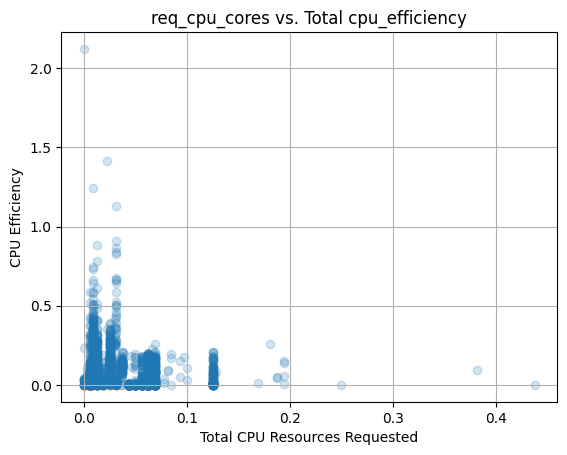

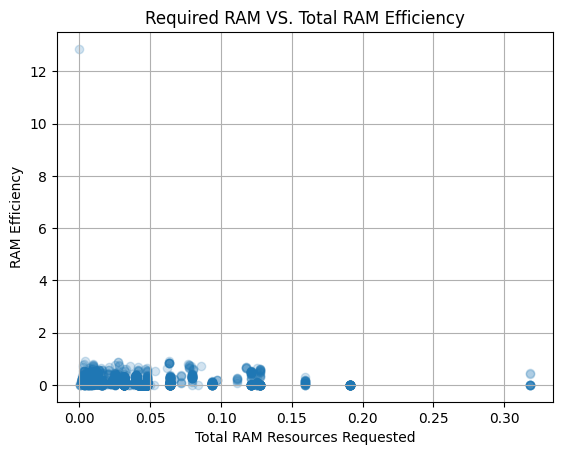

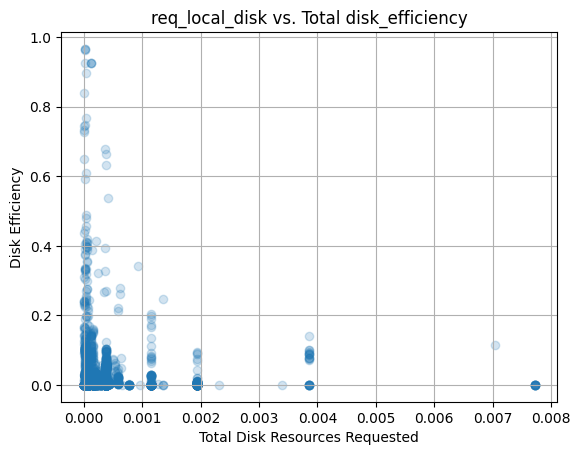

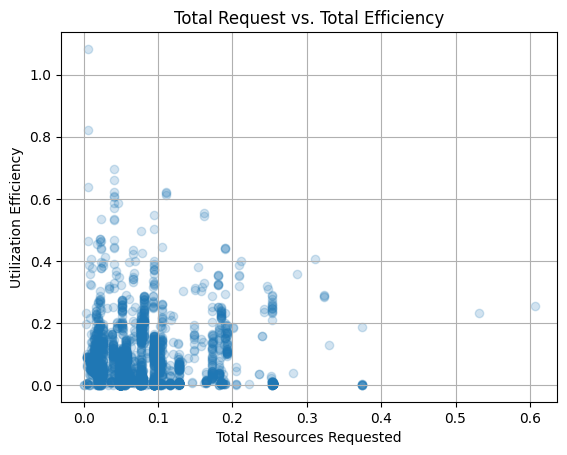

In [119]:
import matplotlib.pyplot as plt
df_sample = df_joined.select("req_cpu_cores", "cpu_efficiency").sample(False, 0.01).toPandas()
plt.scatter(df_sample["req_cpu_cores"], df_sample["cpu_efficiency"], alpha=0.2)
plt.title("req_cpu_cores vs. Total cpu_efficiency")
plt.xlabel("Total CPU Resources Requested")
plt.ylabel("CPU Efficiency")
plt.grid(True)
plt.savefig('images/req_cpu__cpu_efficiency.png', bbox_inches='tight', dpi=300)
plt.show()

df_sample = df_joined.select("req_ram", "ram_efficiency").sample(False, 0.01).toPandas()
plt.scatter(df_sample["req_ram"], df_sample["ram_efficiency"], alpha=0.2)
plt.title("Required RAM VS. Total RAM Efficiency")
plt.xlabel("Total RAM Resources Requested")
plt.ylabel("RAM Efficiency")
plt.grid(True)
plt.savefig('images/req_ram__ram_efficiency.png', bbox_inches='tight', dpi=300)
plt.show()

df_sample = df_joined.select("req_local_disk", "disk_efficiency").sample(False, 0.01).toPandas()
plt.scatter(df_sample["req_local_disk"], df_sample["disk_efficiency"], alpha=0.2)
plt.title("req_local_disk vs. Total disk_efficiency")
plt.xlabel("Total Disk Resources Requested")
plt.ylabel("Disk Efficiency")
plt.grid(True)
plt.savefig('images/req_disk__disk_efficiency.png', bbox_inches='tight', dpi=300)
plt.show()


# sample 1% of the data
df_sample = df_joined.select("total_request", "total_efficiency").sample(False, 0.01).toPandas()
plt.scatter(df_sample["total_request"], df_sample["total_efficiency"], alpha=0.2)
plt.title("Total Request vs. Total Efficiency")
plt.xlabel("Total Resources Requested")
plt.ylabel("Utilization Efficiency")
plt.grid(True)
plt.savefig('images/total_request__total_efficiency.png', bbox_inches='tight', dpi=300)
plt.show()

From this we see that in general, tasks that require more resources don't utilize them so efficiently. When total resources requested increase, there is no imrpovement in efficiency of utilization

### 9. Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

In [120]:
df_task_events.limit(3).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None


In [121]:
df_task_usage.limit(3).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.000842,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.000949,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.018136,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.002097,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000010,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000003,0.000143,21.210,0.104800,0.0,0,0.000037


In [122]:
# 5 minutes = 300000000 ms
window_val = 300000000

df_evict_agg = df_task_events.filter(F.col("event_type") == 2).withColumn("window", (F.col("timestamp") / window_val) \
                             .cast("long")).groupBy("machine_id", "window").agg(F.count("*").alias("eviction_count"))

df_evict_agg.limit(3).toPandas()

,machine_id,window,eviction_count
0,257388826,2560,2
1,3231138163,2560,1
2,2197523778,2561,3


In [123]:
df_usage_peaks = df_task_usage.withColumn("window", (F.col("start_time") / window_val).cast("long")) \
                              .groupBy("machine_id", "window") \
                              .agg( F.max("mean_cpu_usage").alias("peak_cpu"), F.max("canonical_memory_usage").alias("peak_mem"))

df_usage_peaks.limit(3).toPandas()

,machine_id,window,peak_cpu,peak_mem
0,4873175358,2557,0.033876,0.13330
1,336030391,2557,0.019859,0.08032
2,430388230,2557,0.059809,0.13400


In [124]:
df_correlation = df_evict_agg.join(df_usage_peaks, ["machine_id", "window"], "left")
df_correlation.limit(3).toPandas()

,machine_id,window,eviction_count,peak_cpu,peak_mem
0,257388826,2560,2,0.065287,0.16770
1,2197523778,2561,3,0.044569,0.06824
2,3231138163,2560,1,0.015244,0.13310


In [125]:
# Now we calculate correlations:
cpu_corr = df_correlation.stat.corr("peak_cpu", "eviction_count")
mem_corr = df_correlation.stat.corr("peak_mem", "eviction_count")

print(f"Correlation (CPU Peak vs Evictions): {cpu_corr}")
print(f"Correlation (RAM Peak vs Evictions): {mem_corr}")

[Stage 493:>                                                        (0 + 2) / 2]

Correlation (CPU Peak vs Evictions): -0.02580822613255989
Correlation (RAM Peak vs Evictions): -0.028798712910271602


We conclude correlation is low, which means that resource peaks are not the main reason for evictions

### 10. How often does it happen that the resources of a machine are over-committed?

In [126]:
# visual check of df
df_task_events.limit(5).toPandas()

,timestamp,missing_info,job_id,task_index,machine_id,event_type,user_name,scheduling_class,priority,req_cpu_cores,req_ram,req_local_disk,different_machine_constraint
0,767314028182,None,515042969,15,257406228.0,1,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
1,767314057755,None,6319230508,13,6567628.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
2,767314057799,None,6319230508,3,902367.0,4,r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0,4,0.06873,0.00795,0.000038,None
3,767314057847,None,515042969,3,NaN,5,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None
4,767314057850,None,515042969,3,NaN,0,/fk1fVcVxZ6iM6gHZzqbIyq56m5zrmHfpdcZ/zzkq4c=,2,0,0.01562,0.01553,0.000216,None


In [127]:
# visual check of df
df_machines.limit(5).toPandas()

,timestamp,machine_ID,event_type,platform_ID,CPUs,memory_capacity
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [128]:
# visual check of df
df_task_usage.limit(5).toPandas()

,start_time,end_time,job_id,task_index,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,max_memory_usage,mean_disk_io_time,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage
0,767314000000,767400000000,4976640000,0,3231138163,0.000842,0.01645,0.01749,0.000075,0.000162,0.01651,0.000023,0.000074,0.000949,0.000857,2.221,0.003927,0.0,0,0.000019
1,767314000000,767400000000,5960925264,121,4820213301,0.018136,0.02844,0.03461,0.007011,0.007202,0.02856,0.000386,0.000383,0.002097,0.002930,5.187,NaN,0.0,0,0.076540
2,767314000000,767400000000,6183750753,18,216969439,0.000010,0.01816,0.01926,0.000237,0.000313,0.01819,0.000003,0.000000,0.000003,0.000143,21.210,0.104800,0.0,0,0.000037
3,767314000000,767329000000,6219557576,26,3725143539,0.000034,0.00000,0.00000,0.000000,0.000000,0.00000,0.000057,0.000000,0.000032,0.000571,3.957,0.012100,0.0,0,0.000000
4,767314000000,767400000000,6302814662,148,1094423,0.019187,0.04437,0.04572,0.000122,0.000198,0.04565,0.002686,0.000024,0.002489,0.032840,1.976,0.004033,0.0,0,0.011490


In [129]:
# Join task_usage with task_events to get requests for time periods
task_with_requests = df_task_usage.join(
    df_task_events.select("job_id", "task_index", "req_cpu_cores", "req_ram").dropDuplicates(),
    ["job_id", "task_index"],
    "inner"
)

task_with_requests.limit(10).toPandas()

,job_id,task_index,start_time,end_time,machine_id,mean_cpu_usage,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,...,mean_local_disk_space,max_cpu_usage,max_disk_io_time,cpi,mai,sample_portion,aggregation_type,sampled_cpu_usage,req_cpu_cores,req_ram
0,6183750753,18,767314000000,767400000000,216969439,0.000010,0.018160,0.019260,0.000237,0.000313,...,0.000000,0.000003,0.000143,21.210,0.104800,0.0,0,0.000037,0.12500,0.033390
1,6219557576,26,767314000000,767329000000,3725143539,0.000034,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000032,0.000571,3.957,0.012100,0.0,0,0.000000,0.03125,0.006836
2,6312699084,2875,767314000000,767329000000,3725143539,0.000133,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000126,0.000999,24.940,0.105100,0.0,0,0.000000,0.06250,0.039610
3,6314019387,0,767314000000,767332000000,1273561,0.000178,0.000000,0.000000,0.000000,0.000000,...,0.000003,0.000203,0.034300,NaN,NaN,0.0,0,0.000000,0.12500,0.156000
4,6317728539,829,767314000000,767400000000,6566561,0.017727,0.057190,0.058170,0.000382,0.000388,...,0.000040,0.002056,0.009567,1.525,0.002518,0.0,0,0.051570,0.06250,0.121100
5,6317728539,1354,767314000000,767400000000,351604750,0.009141,0.064820,0.065800,0.000376,0.000498,...,0.000020,0.001198,0.010640,1.404,0.002318,0.0,0,0.040890,0.06250,0.121100
6,6318662510,542,767314000000,767400000000,1436312136,0.010337,0.008621,0.013350,0.000441,0.000598,...,0.000003,0.001443,0.000072,2.856,0.004061,0.0,0,0.050720,0.06250,0.031800
7,6318675151,44,767314000000,767400000000,272883522,0.003993,0.007462,0.008286,0.000083,0.000332,...,0.000009,0.001071,0.029420,1.908,0.003730,0.0,0,0.003056,0.06250,0.031800
8,6318675151,349,767314000000,767360000000,8055712,0.011476,0.008865,0.009460,0.000107,0.000421,...,0.000009,0.000965,0.006355,1.248,0.001471,0.0,0,0.023740,0.06250,0.031800
9,6318675151,1481,767314000000,767400000000,1436312136,0.004555,0.007294,0.011260,0.000827,0.001156,...,0.000009,0.000958,0.031740,9.237,0.032430,0.0,0,0.004181,0.06250,0.031800


In [130]:
# For each period (start_time), sum up requests per machine
machine_load_by_period = task_with_requests.groupBy("start_time", "machine_id").agg(
    F.sum("req_cpu_cores").alias("total_cpu_requested"),
    F.sum("req_ram").alias("total_memory_requested"),
    F.count("*").alias("num_tasks")
)

machine_load_by_period.limit(5).toPandas()

,start_time,machine_id,total_cpu_requested,total_memory_requested,num_tasks
0,767316000000,1274569,0.068730,0.079590,1
1,767340000000,1436305689,0.006248,0.004662,1
2,767342000000,565057245,0.068730,0.079590,1
3,767343000000,1272843,0.062500,0.039610,1
4,767347000000,705823,0.012500,0.010300,1


In [131]:
# Machine capacity for periods
machine_capacity = df_machines.filter(
    F.col("event_type").isin([0, 2])  # ADD or UPDATE events
).select(
    "timestamp",
    "machine_id",
    "CPUs",
    "memory_capacity"
).orderBy("machine_id", "timestamp")

machine_capacity.limit(5).toPandas()

,timestamp,machine_id,CPUs,memory_capacity
0,0,5,0.5,0.2493
1,836124903464,5,0.5,0.2493
2,0,6,0.5,0.2493
3,0,7,0.5,0.2493
4,0,10,0.5,0.2493


In [132]:
# join capacity timeline where capacity.timestamp <= load.start_time
capacity_for_period = machine_load_by_period.join(
    machine_capacity,
    (machine_load_by_period.machine_id == machine_capacity.machine_id) &
    (machine_capacity.timestamp <= machine_load_by_period.start_time),
    "left"
).select(
    machine_load_by_period.start_time,
    machine_load_by_period.machine_id,
    machine_load_by_period.total_cpu_requested,
    machine_load_by_period.total_memory_requested,
    machine_load_by_period.num_tasks,
    machine_capacity.timestamp.alias("capacity_timestamp"),
    machine_capacity.CPUs,
    machine_capacity.memory_capacity
)

capacity_for_period.limit(5).toPandas()

,start_time,machine_id,total_cpu_requested,total_memory_requested,num_tasks,capacity_timestamp,CPUs,memory_capacity
0,767316000000,1274569,0.068730,0.079590,1,251252971374,0.5,0.4995
1,767316000000,1274569,0.068730,0.079590,1,0,0.5,0.4995
2,767340000000,1436305689,0.006248,0.004662,1,376276255028,0.5,0.4995
3,767340000000,1436305689,0.006248,0.004662,1,0,0.5,0.4995
4,767342000000,565057245,0.068730,0.079590,1,0,0.5,0.4995


In [133]:
# keep only the most recent capacity for each (start_time, machine_id)
window_spec = Window.partitionBy("start_time", "machine_id") \
    .orderBy(F.desc("capacity_timestamp"))

comparison = capacity_for_period.withColumn(
    "row_num",
    F.row_number().over(window_spec)
).filter(F.col("row_num") == 1).drop("row_num", "capacity_timestamp")

comparison.limit(5).toPandas()

,start_time,machine_id,total_cpu_requested,total_memory_requested,num_tasks,CPUs,memory_capacity
0,752280000000,1094135,0.0625,0.03961,1,0.5,0.2493
1,752280000000,6567471,0.0625,0.03180,1,0.5,0.4995
2,752280000000,6567591,0.0625,0.03180,1,0.5,0.4995
3,752280000000,38744083,0.0625,0.03961,1,0.5,0.2493
4,752280000000,317486393,0.0625,0.03180,1,0.5,0.2493


In [134]:
# Check for over-commitment
over_committed = comparison.withColumn(
    "cpu_overcommitted",
    F.when(F.col("total_cpu_requested") > F.col("CPUs"), 1).otherwise(0)
).withColumn(
    "memory_overcommitted",
    F.when(F.col("total_memory_requested") > F.col("memory_capacity"), 1).otherwise(0)
)

over_committed.limit(5).toPandas()

,start_time,machine_id,total_cpu_requested,total_memory_requested,num_tasks,CPUs,memory_capacity,cpu_overcommitted,memory_overcommitted
0,752280000000,1094135,0.0625,0.03961,1,0.5,0.2493,0,0
1,752280000000,6567471,0.0625,0.03180,1,0.5,0.4995,0,0
2,752280000000,6567591,0.0625,0.03180,1,0.5,0.4995,0,0
3,752280000000,38744083,0.0625,0.03961,1,0.5,0.2493,0,0
4,752280000000,317486393,0.0625,0.03180,1,0.5,0.2493,0,0


In [135]:
# Calculate frequency
total_measurements = comparison.count()
cpu_overcommit = over_committed.filter(F.col("cpu_overcommitted") == 1).count()
mem_overcommit = over_committed.filter(F.col("memory_overcommitted") == 1).count()

In [136]:
total_measurements

2358390

In [137]:
cpu_overcommit

14009

In [138]:
mem_overcommit

9548

In [139]:
# percentage CPU overcommitment 
cpu_overcommit / total_measurements * 100

0.5940069284554294

In [140]:
# percentage memory overcommitment 
mem_overcommit / total_measurements * 100

0.4048524629090184

In [141]:
# varify numbers by counting total occurances of overcommitment
any_overcommit = over_committed.filter((F.col("cpu_overcommitted") == 1) | (F.col("memory_overcommitted") == 1)).count()
any_overcommit

20172

In [142]:
14009 + 9548

23557

In [143]:
# Check for simultaneous over-commitment
both_overcommitted = over_committed.filter((F.col("cpu_overcommitted") == 1) & (F.col("memory_overcommitted") == 1)).count()
both_overcommitted

3385

In [144]:
20172 + 3385

23557

In [145]:
any_overcommit / total_measurements * 100

0.8553292712401257

In [146]:
both_overcommitted / total_measurements * 100

0.1435301201243221

2,358,390 machine-time period measurements were analysed by joining task_usage data with task_events to get resource requests for each running task and aggregating the total requested resources per machine per time period (in 5-minute windows). For  each period the machine capacity was matched with the total requested resources. The result compares the total requested resources against available capacity.

As a result it can be said, that machine resources are overcommitted approximately 0.86% of the time. Specifically CPU is overcommitted 0.59% of the time and memory is overcommitted 0.40% of the time. Both of them are overcommitted at the same time in 0.14% of the time.

## 11. Original question 1 - Are high-priority tasks evenly distributed across all machines, or are they concentrated on a few specific machines?

In [147]:
df_high_priorities = df_task_events.select("job_id", "task_index", "machine_id", "priority").filter(F.col("priority") > 8)
df_high_priorities.limit(3).toPandas()

,job_id,task_index,machine_id,priority
0,6282133822,435,257347123.0,9
1,6256516525,30,6566931.0,10
2,6256516525,30,NaN,10


In [148]:
df_high_priorities.select("machine_id").distinct().count()

5966

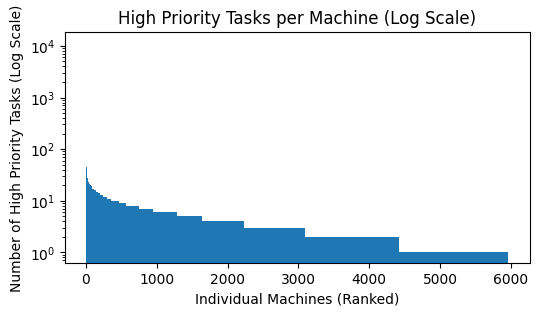

In [149]:
machine_counts = df_high_priorities.groupBy("machine_id").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(6, 3))
plt.bar(range(len(machine_counts)), machine_counts['count'], width=1.0)
plt.yscale('log') # This is the magic line
plt.xlabel("Individual Machines (Ranked)")
plt.ylabel("Number of High Priority Tasks (Log Scale)")
plt.title("High Priority Tasks per Machine (Log Scale)")
plt.savefig('images/high_priority_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

In [150]:
machine_counts

,machine_id,count
0,NaN,11805
1,4.304148e+09,123
2,1.273561e+06,86
3,6.201460e+09,65
4,2.847579e+08,65
...,...,...
5961,4.875410e+05,1
5962,2.198019e+09,1
5963,2.948472e+08,1
5964,7.109490e+05,1


We analyzed how high-priority tasks (Priority 4+) are distributed across the cluster by counting the number of tasks executed per machine.

Observation: Our data shows that important tasks are packed together. A very small group of machines handles almost all the important work (about 12,000 tasks each). Meanwhile, thousands of other machines handle almost zero important tasks. We used log scale for visualization, because otherwise, the machines with only a few tasks would look like zero on the graph.

What this means for the cluster

- Grouping (Packing): Google’s system likes to put important tasks together. They probably pick their best and most reliable machines for this work.
- Efficiency: Keeping these tasks close together makes them run faster and saves space on other machines for different types of work.
- Risk: This is a bit risky. Since so many important tasks are on the same few machines, if one of those machines breaks, a lot of important work stops at the same time.